# DEM Differencing Script for Snow Modelling Research
### Author: Alex Olsen-Mikitowicz
### Course: NR 427 - Programming for GIS
### Date: 14 May 2020

<img src= "https://today-archive.colostate.edu/userfiles/images/ram_logo_275(2).jpg" width=140 height=140 />

In [1]:
#List of libraries used
import os
import fiona
import richdem as rd
import earthpy as ep
import numpy as np
import rasterio as rio
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

### 1. First we will point to our data: 
#### a. Folder containing DEM's 
#### b. Folder containing a mask used to crop out DEM areas so all resulting rasters will be the same dimension

In [2]:
#Set/Point to path where raw elevation rasters are located on your machine/cloud
dem_path = input("Paste the folder path of your raster(s) that need processing (slope, aspect, curvature), hit enter: ")
#E:\GraduateResearch\LIDAR_Data\19-20\Rasters\1x1cm\UPC\raw_rasters

Paste the folder path of your raster(s) that need processing (slope, aspect, curvature), hit enter: E:\GraduateResearch\LIDAR_Data\19-20\Rasters\1x1cm\UPC\raw_rasters


In [9]:
#Set point to path where the mask for your rasters is located (might need to be .shp file)
mask_path_input = input("Paste the raster mask path to the shapefile (.shp) you will use for all processing at this location, hit enter: ")
#E:\GraduateResearch\LIDAR_Data\19-20\Rasters\1x1cm\UPC\Masks\UPC_mask2.shp

Paste the raster mask path to the shapefile (.shp) you will use for all processing at this location, hit enter: E:\GraduateResearch\LIDAR_Data\19-20\Rasters\1x1cm\UPC\Masks\UPC_mask2.shp


In [32]:
#navigate to your dem differencing ouput folder
dem_diff_output = input("Paste the folder path to where your dem differencing outputs will go: ")
#E:\GraduateResearch\LIDAR_Data\19-20\Rasters\1x1cm\UPC\differenced_rasters

Paste the folder path to where your dem differencing outputs will go: E:\GraduateResearch\LIDAR_Data\19-20\Rasters\1x1cm\UPC\differenced_rasters


In [33]:
#prints path entered
print("Your DEM path is: " + dem_path)
print("Your Mask path is: " + mask_path_input)  
print("You DEM differencing path is: " + dem_diff_output)
#change working directory to dem locations for further processing
os.chdir(dem_path)

Your DEM path is: E:\GraduateResearch\LIDAR_Data\19-20\Rasters\1x1cm\UPC\raw_rasters
Your Mask path is: E:\GraduateResearch\LIDAR_Data\19-20\Rasters\1x1cm\UPC\Masks\UPC_mask2.shp
You DEM differencing path is: E:\GraduateResearch\LIDAR_Data\19-20\Rasters\1x1cm\UPC\differenced_rasters


In [34]:
#create list of DEM's and print list
dem_list = os.listdir(dem_path)
print("The length of your raster list is: " + str(len(dem_list)))
print(dem_list)

The length of your raster list is: 5
['20200211.tif', '20200124.tif', '20200108.tif', '20191202.tif', '20191115.tif']


### 2. Create folders for output rasters by method - will be used later in loop

In [35]:
#check if subfolders are created for DEM differencing outputs, if not create them

#set relative paths for DEM differencing output
static_path = dem_diff_output + str("\\static_differencing\\")
dynamic_path = dem_diff_output + str("\\dynamic_differencing\\")


In [37]:
# Check whether the specified path is an existing directory, if not create folders    
if not os.path.exists(static_path):
    #os.chdir(static_path)
    os.makedirs(static_path)

if not os.path.exists(dynamic_path):
    #os.chdir(dynamic_path)
    os.makedirs(dynamic_path)
    
print("Your DEM differencing outputs will be in folders 'dynamic_differencing' and 'static_differencing' under your selected output folder")

Your DEM differencing outputs will be in folders 'dynamic_differencing' and 'static_differencing' under your selected output folder


### 3. Using mask for cropping rasters

In [38]:
#importing mask with fiona and name variable shape
with fiona.open(mask_path_input, "r") as shapefile:
    shape = [feature["geometry"] for feature in shapefile]


In [39]:
#Check mask shape is in right format
print(shape)

[{'type': 'Polygon', 'coordinates': [[(1.6694654377880205, 0.7687096531201129), (1.6694654377880205, 0.9003382800878474), (4.4519003568728435, 0.9003382800878474), (4.4519003568728435, -2.0301713959072614), (1.6694654377880205, -2.0301713959072614), (1.6694654377880205, 0.7687096531201129)]]}]


### 4. Dynamic differencing loop for creating and saving difference rasters

### Still needs: 
#### 1. figure out masking for nodatavalues and put correct metadata in the differenced raster
#### 2. figure out why 20191202.tif is not the same size as the rest


In [28]:
#Double check working directory
#os.getcwd()

In [40]:
dem_list

['20200211.tif',
 '20200124.tif',
 '20200108.tif',
 '20191202.tif',
 '20191115.tif']

In [41]:
#reverse dem_list to get it in appropriate order earliest - latest
list.reverse(dem_list)
dem_list

['20191115.tif',
 '20191202.tif',
 '20200108.tif',
 '20200124.tif',
 '20200211.tif']

In [42]:
#go to appropriate working directory
os.chdir(dem_path)

In [43]:
#Dynamic differencing output looks like I have the rasters rearranged in the wrong order - getting negative differences instead of positive ones

#dynamic differencing iterator
#open rasters and crop by mask
from rasterio.mask import mask

#process for all rasters: open with rasterio, mask, crop, and create output variables
counter = 0
diff_dict = {}
diff_dict2 = {}
for dem, next_dem in zip(dem_list, dem_list[1:]):
    
    #code for parsing names of list objects in loop
    dem1_id = dem.split(".")[0]
    dem2_id = next_dem.split(".")[0]
    diff_id = str(dem2_id) + "-" + str(dem1_id) + ".tif"
 
    with rio.open(dem) as src1:
        out_image1, out_transform1 = mask(src1, shape, crop=True)
        out_meta1 = src1.meta
        r1 = out_image1[0]
    
    with rio.open(next_dem) as src2:
        out_image2, out_transform2 = mask(src2, shape, crop=True)
        out_meta2 = src2.meta
        r2 = out_image2[0]
        
    if r1.shape == r2.shape:
        dynamic_diff = r2 - r1
        with rio.open(dynamic_path + diff_id, 'w', **out_meta1) as outrast:
            outrast.write(dynamic_diff, 1)
    else:
        r1_shape = r1.shape
        r2_shape = r2.shape
        print("Could not difference: " + next_dem + " - " + dem)
        print("Raster size discrepancies: " + str(r2_shape) + " " + str(r1_shape))
    
    counter = counter + 1

#creates a dictionary of dems used in the loop - dont know if I need this yet
    diff_dict["dem{0}".format(str(counter))] = dem
    diff_dict2["dem{0}".format(str(counter))] = next_dem


Could not difference: 20191202.tif - 20191115.tif
Raster size discrepancies: (294, 280) (294, 279)
Could not difference: 20200108.tif - 20191202.tif
Raster size discrepancies: (294, 279) (294, 280)


In [30]:
#Glimpse at dictionaries created
#print(diff_dict)
#print(diff_dict2)

### 5. Static differencing loop for creating and saving difference rasters

In [108]:
#creat new list static_list and remove first item so it doesnt iterate
#dont run this multiple times because it will keep removing the first item of the list every time you run it

#the problem is - I am popping the wrong raster out. I need to pop('20191115.tif') and I am currently popping ('20200211.tif')
static_list = dem_list.copy()
anchor_dem = static_list.pop()
static_list

#static_list_copy = static_list.copy()

['20200211.tif', '20200124.tif', '20200108.tif', '20191202.tif']

In [109]:
#testing DEM list: probably dont need
dem_list

['20200211.tif',
 '20200124.tif',
 '20200108.tif',
 '20191202.tif',
 '20191115.tif']

In [110]:
#make a string for the static raster used for naming output later
static_dem_whole = anchor_dem
static_dem_name = static_dem_whole.split(".")[0]
print(static_dem_name)

20191115


In [111]:
#testing current working directory - probably dont need
os.getcwd()

'E:\\GraduateResearch\\LIDAR_Data\\19-20\\Rasters\\1x1cm\\UPC\\differenced_rasters\\static_differencing'

In [116]:
#open and mask/crop the first dem in the whole list to use for static differencing in next chunk

#had to change paths to locate dem_list[0] for opening
os.chdir(dem_path)

with rio.open(anchor_dem) as static_dem:
    static_image, static_transform = mask(static_dem, shape, crop=True)
    static_meta = static_dem.meta
    static_raster_anchor = static_image[0]

In [117]:
#static differencing iterator
#open raster starting with second raster in dem_list and crop by mask for items in static_list, difference with static_raster


#process for all rasters: open with rasterio, mask, crop, and create output variables
counter = 0
diff_dict_static = {}

for dem in static_list:
    
    #code for parsing names of list objects in loop
    dem_id = dem.split(".")[0]
    diff_id = str(dem_id) + "-" + str(static_dem_name) + ".tif"
 
    with rio.open(dem) as src:
        out_image, out_transform = mask(src, shape, crop=True)
        out_meta = src.meta
        static_raster_next = out_image[0]
    
    if static_raster_anchor.shape == static_raster_next.shape:
        static_diff = static_raster_next - static_raster_anchor
        with rio.open(static_path + diff_id, 'w', **out_meta) as outrast:
            outrast.write(static_diff, 1)
    else:
        dem_id_shape = static_raster_anchor.shape
        static_dem_name_shape = static_raster_next.shape
        print("Could not difference: " + dem_id + " - " + static_dem_name)
        print("Raster size discrepancies: " + str(dem_id_shape) + " " + str(static_dem_name_shape))
    counter = counter + 1
    
#need to difference dems in a loop if they match in shape

#creates a dictionary of dems used in the loop - dont know if I need this yet
    diff_dict_static["dem{0}".format(str(counter))] = dem
    

    
#need to save dem difference product as new file
    #with rio.open(test_path, 'w', **diff_meta) as outrast:
        #outrast.write(diff, 1)

Could not difference: 20191202 - 20191115
Raster size discrepancies: (294, 279) (294, 280)


### 6. Plot the differenced elevation rasters - Static Differencing Method

['20200211-20191115.tif', '20200124-20191115.tif', '20200108-20191115.tif']


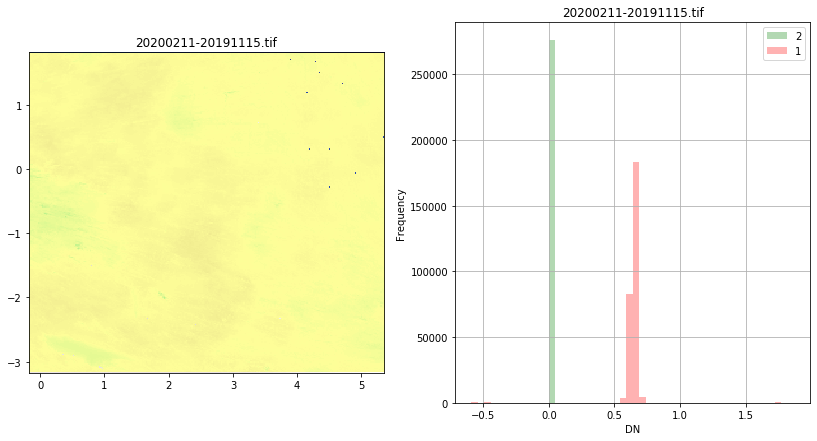

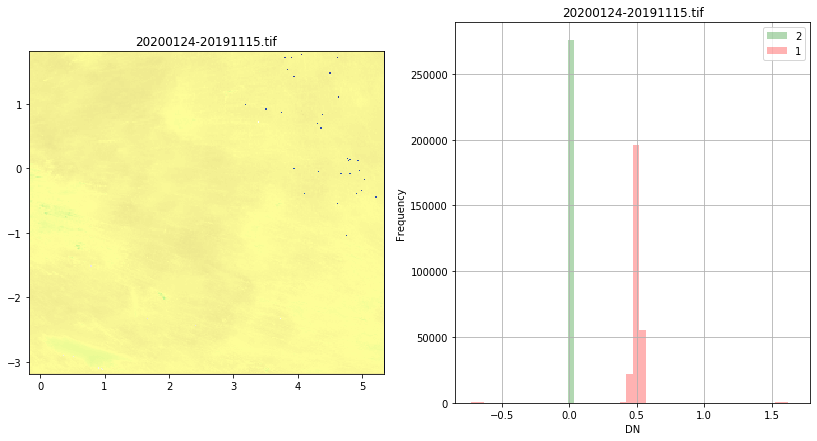

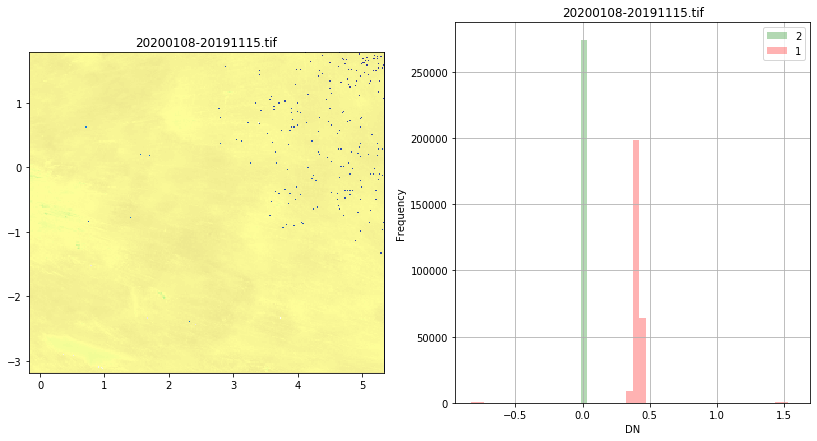

In [119]:
#plotting all differenced raster elevation bands
from rasterio.plot import show
%matplotlib inline

#change directory to location of static method differenced elevation rasters
os.chdir(static_path)
#os.getcwd()

#make list of files located in directory
static_diff_list = os.listdir(static_path)
print(static_diff_list)

#start counter and dictionary for referencing rasters later
static_counter = 0
static_dict = {}

for difrast in static_diff_list:
    with rio.open(difrast) as open_static_drast:
        #show(open_static_drast)
        #open_static_drast
        #I dont know if a dictionary is the proper use here for calling the rio.open(differenced raster)
        
        #plot results of differencing within loop
        from matplotlib import pyplot
        from rasterio.plot import show_hist
        fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
        show(open_static_drast,cmap = "terrain", ax=axrgb)

        show_hist(open_static_drast, bins=50, histtype='stepfilled',
               lw=0.0, stacked=False, alpha=0.3, ax=axhist)
        axrgb.set_title(open_static_drast.name)
        axhist.set_title(open_static_drast.name)
        pyplot.show()
        
    static_dict["static_dif_rast{0}".format(str(static_counter))] = open_static_drast
    static_counter = static_counter + 1


    
#static_dict
#ask beth about dictionaries and plotting all the static_differenced_rasters on same plot with matplotlib

### 7. Plot the differenced elevation rasters - Dynamic Differencing Method

['20200124-20200108.tif', '20200211-20200124.tif']


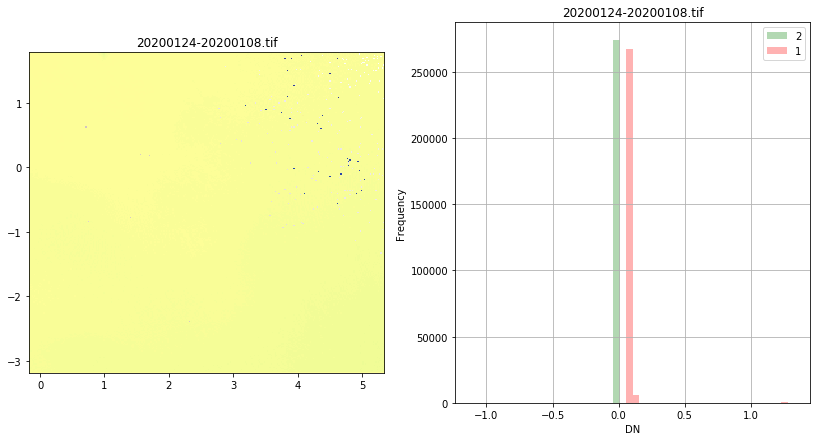

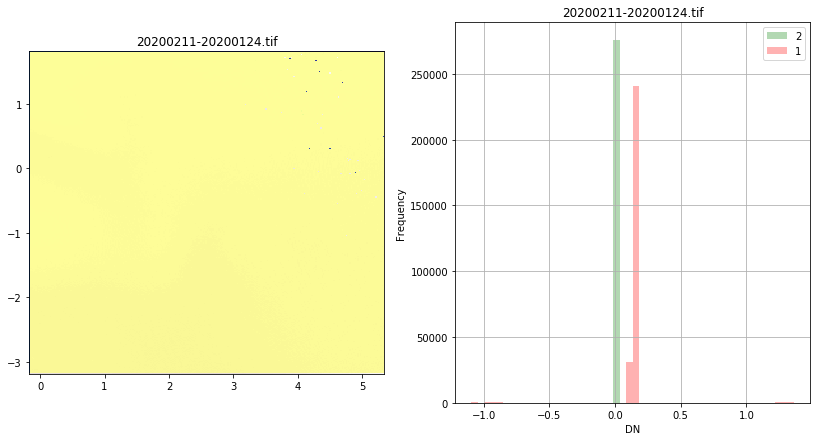

In [141]:
#plotting all differenced raster elevation bands
from rasterio.plot import show
%matplotlib inline

#change directory to location of static method differenced elevation rasters
os.chdir(dynamic_path)
#os.getcwd()

#make list of files located in directory
dynamic_diff_list = os.listdir(dynamic_path)
print(dynamic_diff_list)

#start counter and dictionary for referencing rasters later
dynamic_counter = 0
dynamic_dict = {}

for difrast in dynamic_diff_list:
    with rio.open(difrast) as open_dynamic_drast:
        #show(open_static_drast)
        #open_static_drast
        #I dont know if a dictionary is the proper use here for calling the rio.open(differenced raster)
        
        #plot results of differencing within loop
        from matplotlib import pyplot
        from rasterio.plot import show_hist
        fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
        show(open_dynamic_drast,cmap = "terrain", ax=axrgb)

        show_hist(open_dynamic_drast, bins=50, histtype='stepfilled',
               lw=0.0, stacked=False, alpha=0.3, ax=axhist)
        axrgb.set_title(open_dynamic_drast.name)
        axhist.set_title(open_dynamic_drast.name)
        pyplot.show()
        
    dynamic_dict["static_dif_rast{0}".format(str(dynamic_counter))] = open_dynamic_drast
    dynamic_counter = dynamic_counter + 1


    
#static_dict
#ask beth about dictionaries and plotting all the static_differenced_rasters on same plot with matplotlib

TypeError: Image data of dtype <U21 cannot be converted to float

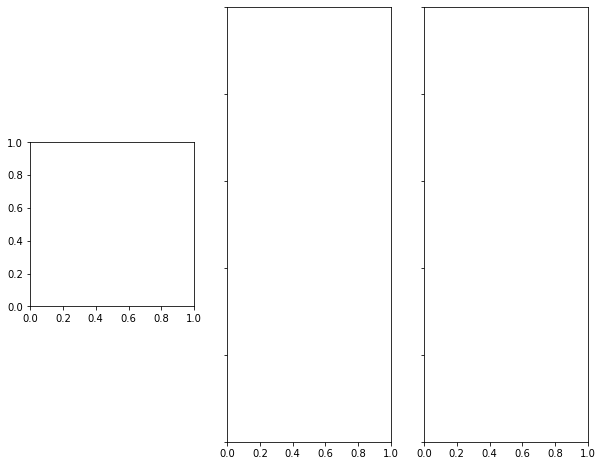

In [85]:
#trying to plot the 3 differenced rasters with matplotlib in line
from rasterio.plot import show
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, nrows = 1, figsize = (10,8), sharey = True)
show(static_diff_list[0], cmap="terrain", ax = ax1)
show(static_diff_list[1], cmap="terrain", ax = ax2)
show(static_diff_list[2], cmap="terrain", ax = ax3)
ax1.set_title(static_diff_list[0])
ax2.set_title(static_diff_list[1])
ax3.set_title(static_diff_list[2])

### 6. Plot the selected elevation rasters - implement over all rasters

In [ ]:
#plotting all differenced raster elevation bands
from rasterio.plot import show
%matplotlib inline

os.chdir(static_path)
#os.getcwd()

fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, nrows = 1, figsize = (10,8), sharey = False)
show(out_image_src1[0], cmap="terrain", ax = ax1)
show(out_image_src2[0], cmap="terrain", ax = ax2)
ax1.set_title('20191115.tif')
ax2.set_title('20200211.tif')

In [ ]:
#check metadata for both rasters
print(out_meta_src1)
print(out_meta_src2)

In [ ]:
#separate bands and take only elevation band for both rasters
r1 = out_image_src1[0]
r2 = out_image_src2[0]
print(r1.shape)
print(r2.shape)

### 7.  Difference the rasters and plot results - probably can delete

In [ ]:
#Difference the elevation band
diff1 = r2 - r1
diff1.shape
#show(diff[0], cmap = "terrain")


In [ ]:
#plot results of differencing
from matplotlib import pyplot
from rasterio.plot import show_hist
fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
show(diff1,cmap = "terrain", ax=axrgb)

show_hist(diff1, bins=70, histtype='stepfilled',
           lw=0.0, stacked=False, alpha=0.3, ax=axhist)
pyplot.show()

### 8. Save the raster to a local directory - probably can delete

In [ ]:
#Copy metadata from src1 - need to fix and update nodata value to -999
diff_meta = src1.meta.copy()

In [ ]:
#set path and name for saving difference raster
test_path = r"E:\GraduateResearch\LIDAR_Data\19-20\Rasters\1x1cm\UPC\test_differencing\20200211-20191115.tif"

In [ ]:
#save raster difference to test_path
if not os.path.exists(dynamic_path):
    with rio.open(test_path, 'w', **diff_meta) as outrast:
        outrast.write(diff1, 1)

### Plotting various landscape features of differenced raster
#### a. Slope
#### b. Aspect
#### c. Profile Curvature
#### d. Planform Curvature
#### e. Curvature

In [ ]:
#point to the newly saved difference raster
diff1 = r"E:\GraduateResearch\LIDAR_Data\19-20\Rasters\1x1cm\UPC\test_differencing\20200211-20191115.tif"

In [ ]:
#use richdem (rd) to create different surface feature plots
elev_diff1 = rd.LoadGDAL(diff1)

In [ ]:
#slope
slope_diff1 = rd.TerrainAttribute(elev_diff1, attrib='slope_riserun')
rd.rdShow(slope_diff1, axes=False, cmap='jet', figsize=(8,5.5))

In [ ]:
#aspect
aspect_diff1 = rd.TerrainAttribute(elev_diff1, attrib='aspect')
rd.rdShow(aspect_diff1, axes=False, cmap='jet', figsize=(8,5.5))

In [ ]:
#profile curvature
profile_curvature_diff1 = rd.TerrainAttribute(elev_diff1, attrib='profile_curvature')
rd.rdShow(profile_curvature_diff1, axes=False, cmap='jet', figsize=(8,5.5))

In [ ]:
#planform curvature
planform_curvature_diff1 = rd.TerrainAttribute(elev_diff1, attrib='planform_curvature')
rd.rdShow(planform_curvature_diff1, axes=False, cmap='jet', figsize=(8,5.5))

In [ ]:
#curvature
curvature_diff1 = rd.TerrainAttribute(elev_diff1, attrib='curvature')
rd.rdShow(curvature_diff1, axes=False, cmap='jet', figsize=(8,5.5))

### Nevermind the rest of this code. It is for implementing the above tasks into a loop

In [ ]:
#code for naming difference output tifs - MOVE TO LOOP - Might not need
dem1 = dem_list[1]
dem2 = dem_list[2]
dem1date = dem1.split(".")[0]
dem2date = dem2.split(".")[0]
dem_diff = str(dem2date) + "-" + str(dem1date) + ".tif"
dem_diff

In [ ]:
#dont think I need anymore. . .
#working chunk: Iterating differencing
counter = 0
for dem, next_dem in zip(dem_list, dem_list[1:]):
    #section for parsing and naming difference raster
    dem1date = dem.split(".")[0]
    dem2date = next_dem.split(".")[0]
    dem_diff_name = str(dem2date) + "-" + str(dem1date) + ".tif"
    
    #section for raster differencing - ***rasters need to be the same size
    with rio.open(dem) as src1:
        r1 = src1.read(1)
    with rio.open(next_dem) as src2:
        r2 = src2.read(1)
    diff = r2 - r1
    counter = counter + 1
    
    #saving the difference raster file to created foled (dynamic_path)
    out_tif = dynamic_path + dem_diff_name #location+filename
    with rio.open(out_tif, "w") as dest: #***might not work - took out ,**out_meta after "w" - look at lesson5c for reference
        dest.write(diff)
    

In [ ]:
#dont think I need anymore . . .
#iterate over DEM list and perform raster math in the fashion: 2-1, 3-1, . . . n-1
#place results in static_differencing folder
counter = 0
for num, dem in enumerate(dem_list):
    print("{}: {}".format(num, dem))
    counter = counter + 1



In [ ]:
#run richdem functions to produce slope, aspect, profile_curvature, and planform_curvature - this needs to be made iterable
for dem in dem_list:
    elev = rd.LoadGDAL(dem)
    slope = rd.TerrainAttribute(elev, attrib='slope_riserun')
    aspect = rd.TerrainAttribute(elev, attrib='aspect')
    profile_curvature = rd.TerrainAttribute(elev, attrib='profile_curvature')
    planform_curvature = rd.TerrainAttribute(elev, attrib='planform_curvature')
  